In [1]:
import sys
sys.path.append("..")

In [2]:
import wfdb

from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    positions, labels = trigger_points(annotation, with_labels=True)
    return record, positions, labels

def read_records(directory, names, sampto):
    records, positions, labels = [], [],  []
    for name in names:
        path = "/".join([directory, name])
        record, pos, labs = read_record(path, sampto)
        records.append(record)
        positions.append(pos)
        labels.append(labs)
    return records, positions, labels

In [3]:
record_dir = "../physionet.org/files/mitdb/1.0.0"
test_path = '/'.join([record_dir, '106'])
train_names = ["100", "101", "102", "103", "104"]
sampto = 10000

train_records, train_positions, train_labels = read_records(record_dir, train_names, sampto)
test_record, test_positions, test_labels = read_record(test_path, sampto)

In [18]:
from raccoon.detectors import GarciaBerdonesDetector, SarlijaDetector, XiangDetector

gbd = GarciaBerdonesDetector(
    name = "Garcia-Berdones",
    batch_size = 32,
    window_size = 20,
    epochs = 3)

sd = SarlijaDetector(
    name = "Sarlija",
    batch_size = 32,
    window_size = 40,
    detection_size=20,
    epochs = 3)

xd = XiangDetector(
    name='Xiang',
    batch_size=32,
    window_size=40,
    detection_size=20,
    aux_ratio=5,
    epochs=3)

In [19]:
gbd.train(train_records, train_positions)
sd.train(train_records, train_positions)
xd.train(train_records, train_positions)

Epoch 1/3
1559/1559 [==============================] - 3s 2ms/step - loss: 0.0899
Epoch 2/3
1559/1559 [==============================] - 2s 1ms/step - loss: 0.0406
Epoch 3/3
1559/1559 [==============================] - 2s 1ms/step - loss: 0.0370
Epoch 1/3
1556/1556 [==============================] - 11s 7ms/step - loss: 0.1119
Epoch 2/3
Epoch 1/3
1556/1556 [==============================] - 11s 7ms/step - loss: 0.0689
Epoch 3/3
1556/1556 [==============================] - 11s 7ms/step - loss: 0.0614
Epoch 3/3
Epoch 1/3
1556/1556 [==============================] - 4s 3ms/step - loss: 0.0841
Epoch 2/3

1556/1556 [==============================] - 4s 3ms/step - loss: 0.0240
Epoch 3/3
1556/1556 [==============================] - 4s 3ms/step - loss: 0.0218


In [20]:
gbd_ts = gbd.trigger_signal(test_record)
sd_ts = sd.trigger_signal(test_record)
xd_ts = xd.trigger_signal(test_record)

In [21]:
from raccoon.utils.triggerutils import signal_to_points

gbd_dets, gbd_certs = signal_to_points(gbd_ts, with_certainty=True)
sd_dets, sd_certs = signal_to_points(sd_ts, with_certainty=True)
xd_dets, xd_certs = signal_to_points(xd_ts, with_certainty=True)

In [22]:
from itertools import repeat
import pandas as pd

df = pd.concat([
    pd.DataFrame(zip(gbd_dets, gbd_certs, repeat(gbd.name))),
    pd.DataFrame(zip(sd_dets, sd_certs, repeat(sd.name))),
    pd.DataFrame(zip(xd_dets, xd_certs, repeat(xd.name)))])

df.columns = ['Position', 'Certainty', 'Detector']

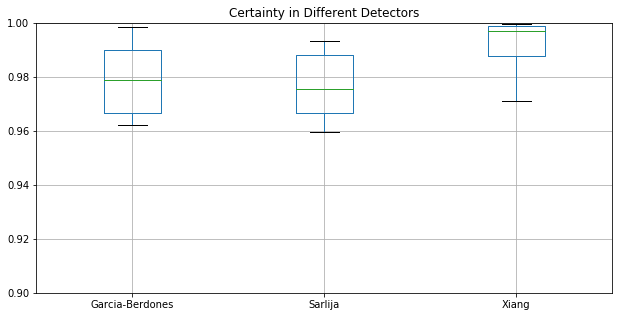

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

df.boxplot(
    column='Certainty', by='Detector', ax=ax,
    flierprops=dict(markerfacecolor='b', marker='x'))

ax.set_ylim(0.9,1)
ax.set_xlabel("")
ax.set_title("Certainty in Different Detectors")
fig.suptitle("")

ax

In [14]:
fig.savefig(
    '../generated/figures/impact_detector.pdf',
    format='pdf',
    bbox_inches = 'tight',
    pad_inches = 0.1)

In [13]:
from scipy.stats import ttest_ind

print(ttest_ind(
    df[df.Label == 'Normal Beat'].Certainty,
    df[df.Label == 'Premature Ventricular Contraction'].Certainty,
    nan_policy='omit'))

print(ttest_ind(
    df[df.Label == 'False Positive'].Certainty,
    df[df.Label == 'Premature Ventricular Contraction'].Certainty,
    nan_policy='omit'))

Ttest_indResult(statistic=9.632542243390333, pvalue=1.8062032006926407e-21)
Ttest_indResult(statistic=-16.536566154254746, pvalue=2.0877376800388202e-54)
